In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import AutoImageProcessor, EfficientNetModel
from chromadb.api.types import Documents, EmbeddingFunction, Embeddings
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import uuid
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

from pathlib import Path
import numpy as np
from tqdm import tqdm
from collections import OrderedDict
from basevectordb import BaseVectorDB

# import tensorflow as tf
# import compress_pickle
from chromadb import Client, PersistentClient

from chromadb.utils import embedding_functions
from chromadb.utils.data_loaders import ImageLoader
from chromadb.api.types import Documents, EmbeddingFunction, Embeddings
import os
import hashlib
import numpy as np
from datetime import datetime
from typing import Dict, List, Tuple
from pathlib import Path
import json
import random

/home/t/atest/reverse-image-search/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


def plot_images_grid(image_paths, titles, grid_size=(2, 2)):

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    for i in range(len(image_paths)):
        img = mpimg.imread(image_paths[i])
        axes[i].imshow(img)
        axes[i].set_title(titles[i])
        axes[i].axis("off")  # Hide axes for better display

    # plt.tight_layout()
    plt.show()

In [3]:
def get_random_image(dir:str|Path) -> str:
    if isinstance(dir, str):
        dir = Path(dir)
    image_paths = list(dir.glob("**/*"))
    
    if image_paths:
        random.shuffle(image_paths)
        return str(image_paths[0].absolute())

In [4]:
from transformers import AutoModel

In [5]:
from pathlib import Path
from transformers import AutoImageProcessor, AutoModel
from chromadb.api.types import Documents, EmbeddingFunction, Embeddings
from PIL import Image
import torch
import numpy as np


class EfficientNetEmbeddingFunction(EmbeddingFunction[Documents]):
    """To use this EmbeddingFunction, you must have the google.generativeai Python package installed and have a PaLM API key."""

    def __init__(self, model_name: str = "google/efficientnet-b0", device="cuda"):
        self.device = (
            "cuda" if torch.cuda.is_available() and device == "cuda" else "cpu"
        )
        self._model_name = model_name
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)
        # self.model = EfficientNetModel.from_pretrained(model_name).to(self.device)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)

    def load_image(self, image: str | Path | Image.Image | np.ndarray):
        """
        Loads an image and processes it using the model's image processor.
        Reusable helper function for single and batch image processing.
        """
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)  # Convert np.ndarray to PIL Image
        

        if isinstance(image, str) or isinstance(image, Path):
            image = Image.open(image)

        if image.mode != "RGB":
            image = image.convert("RGB")

        image = self.image_processor(images=image, return_tensors="pt").to(self.device)

        return image["pixel_values"]

    def _embed(self, pixel_values):
        """
        Helper function to perform model inference and return the embeddings.
        """
        with torch.no_grad():
            outputs = self.model(pixel_values=pixel_values)
        return outputs.pooler_output

    def embed_image(self, image):
        """
        Embeds a single image by first loading and processing it, then passing it to the model.
        """
        pixel_values = self.load_image(image)
        embeddings = self._embed(pixel_values)
        return embeddings.cpu().numpy().tolist()

    def batch_embed_images(
        self, images: list[str | Path | Image.Image | np.ndarray], batch_size: int = 32
    ):
        """
        Embeds a batch of images, processing them in batches of the specified batch_size.
        """
        all_embeddings = []

        for i in range(0, len(images), batch_size):
            batch = images[i : i + batch_size]
            processed_images = [self.load_image(image) for image in batch]
            batched_images = torch.cat(processed_images).to(self.device)
            batch_embeddings = self._embed(batched_images)
            all_embeddings.extend(batch_embeddings.cpu().numpy().tolist())

        return all_embeddings

    def __call__(
        self, images: list[Image.Image | Path | str], batch_size: int = 8
    ) -> Embeddings:
        return self.batch_embed_images(images, batch_size=batch_size)


In [6]:
import os
import hashlib
import uuid
import json
from pathlib import Path

from typing import Dict, List, Union
from chromadb import PersistentClient
from chromadb.utils.data_loaders import ImageLoader
from chromadb.api.types import EmbeddingFunction

IMAGE_EXTENSIONS = (".jpg", ".jpeg", ".png")  # keep it lowercase

class EmbeddingStore(BaseVectorDB):
    def __init__(
        self,
        save_dir: str,
        embedding_model: EmbeddingFunction,
        collection_name: str = "my_collection",
        cache_file: str = "image_cache.json",
    ):
        self._save_dir = save_dir
        self.image_loader = ImageLoader()
        self.embedding_model = embedding_model
        self.collection_name = collection_name
        self.cache_file = Path(self._save_dir) / cache_file
        self.image_cache = self.load_cache()
        self.setup()
        
    def setup(self):
        self._client = self._initialize_client()
        self.collection = self._get_or_create_collection()

    def _initialize_client(self) -> PersistentClient:
        return PersistentClient(path=self._save_dir)

    def _get_or_create_collection(self):
        return self._client.get_or_create_collection(
            name=self.collection_name,
            embedding_function=self.embedding_model,
            data_loader=self.image_loader,
        )

    def load_cache(self) -> Dict[str, Dict[str, Union[str, float]]]:
        """Load image cache from the cache file if it exists, otherwise return an empty dict."""
        if self.cache_file.exists():
            with open(self.cache_file, "r") as f:
                return json.load(f)
        return {}

    def save_cache(self):
        """Save the current image cache to the cache file."""
        with open(self.cache_file, "w") as f:
            json.dump(self.image_cache, f)

    def get_file_hash(self, file_path: str) -> str:
        """Generate an MD5 hash for a given file."""
        with open(file_path, "rb") as f:
            file_hash = hashlib.md5()
            for chunk in iter(lambda: f.read(8192), b""):
                file_hash.update(chunk)
        return file_hash.hexdigest()

    def _list_images_in_dir(self, image_dir: str) -> List[str]:
        """Return a list of image paths in a directory with valid extensions."""
        return  [
            str(p.absolute())
            for p in Path(image_dir).glob("**/*")
            if p.suffix.lower() in IMAGE_EXTENSIONS
        ]

    def get_updated_image_paths(
        self, 
        image_paths: List[Union[str, Path]] = None, 
        image_dir: Union[str, Path] = None
    ) -> Dict[str, List[tuple[str, str]]]:
        """Return dict containing new and updated image paths based on file hash and modification time."""
        if image_paths is None and image_dir:
            image_paths = self._list_images_in_dir(image_dir)

        new_images, updated_images = [], []

        for image_path in image_paths:
            file_hash = self.get_file_hash(image_path)
            file_mtime = os.path.getmtime(image_path)

            if image_path not in self.image_cache:
                image_id = str(uuid.uuid4())
                new_images.append((image_id, image_path))
                self._update_cache(image_path, image_id, file_hash, file_mtime)
            elif (
                self.image_cache[image_path]["hash"] != file_hash
                or self.image_cache[image_path]["mtime"] != file_mtime
            ):
                image_id = self.image_cache[image_path]["id"]
                updated_images.append((image_id, image_path))
                self._update_cache(image_path, image_id, file_hash, file_mtime)

        return {"new_image_paths": new_images, "updated_image_paths": updated_images}

    def _update_cache(self, image_path: str, image_id: str, file_hash: str, file_mtime: float):
        """Update the image cache with new hash and modification time."""
        self.image_cache[image_path] = {"id": image_id, "hash": file_hash, "mtime": file_mtime}

    def update_images(self, image_paths: List[Union[str, Path]] = None, batch_size: int = 16):
        """Update image embeddings in the collection."""
        paths_info = self.get_updated_image_paths(image_paths=image_paths)
        new_images, updated_images = paths_info["new_image_paths"], paths_info["updated_image_paths"]

        if new_images:
            self._add_images([path for _, path in new_images], [id for id, _ in new_images], batch_size=batch_size)
            print(f"Added {len(new_images)} new images.")

        if updated_images:
            self.update_embeddings([path for _, path in updated_images], [id for id, _ in updated_images])
            print(f"Updated {len(updated_images)} existing images.")

        self.save_cache()

    def update_embeddings(self, image_paths: List[Union[str, Path]], image_ids: List[str]):
        """Update embeddings for given image paths and IDs."""
        embeddings = self.embed_images(image_paths)
        self.collection.update(ids=image_ids, uris=image_paths, embeddings=embeddings)

    def embed_images(self, image_paths: List[str], batch_size: int = 16):
        """Generate embeddings for a list of image paths."""
        return self.embedding_model.batch_embed_images(image_paths, batch_size=batch_size)

    def add_images(
        self,
        image_paths: List[str] = None,
        image_dir: Union[str, Path] = None,
        image_ids: List[str] = None,
        batch_size: int = 16
    ):
        """Add images to the collection from paths or a directory."""
        if image_paths is None and image_dir:
            image_paths = self._list_images_in_dir(image_dir)

        self._add_images(image_paths, image_ids=image_ids, batch_size=batch_size)

    def _add_images(self, image_paths: List[str], image_ids: List[str] = None, batch_size: int = 16):
        """Helper method to handle image addition logic."""
        if image_ids is None:
            image_ids = [str(uuid.uuid4()) for _ in image_paths]

        embeddings = self.embed_images(image_paths, batch_size=batch_size)
        self.collection.add(ids=image_ids, uris=image_paths, embeddings=embeddings)

        for id, path in zip(image_ids, image_paths):
            file_hash = self.get_file_hash(path)
            file_mtime = os.path.getmtime(path)
            self._update_cache(path, id, file_hash, file_mtime)

        self.save_cache()

    def get_n_similar_images(self, image: str, k: int = 5):
        """Return the top `k` similar images for a given image."""
        return self.collection.query(
            query_uris=image,
            include=["uris", "distances", "metadatas", "embeddings", "documents"],
            n_results=k,
        )

    def delete_collection(self):
        """Delete the current collection from the client."""
        self._client.delete_collection(self.collection_name)
        
    def delete_embeddings(self, image_dir:str|Path=None, image_paths:list[str]=None):
        
        if image_dir:
            if isinstance(image_dir, str):
                image_dir = Path(image_dir)
                assert image_dir.is_dir(), f"The directory '{image_dir}' does not exist."
                
            image_paths = [str(i.absolute()) for i in image_dir.iterdir()]
        
        out = self.collection.query(query_uris=image_paths, include=['uris'], n_results=1)
        uris =  np.ravel(out['uris']).tolist()
        ids =   np.ravel(out['ids']).tolist()
        
        delete_ids = [idd for idd, uri in zip(ids, uris) if uri in image_paths]
        self.collection.delete(ids=delete_ids)
        print(f'deleted {len(delete_ids)} embeddins!')

In [7]:
def plot_image(image_path):
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.show()

In [8]:
a = EfficientNetEmbeddingFunction()
# images = ["./sad-china.jpg", "animal.jpg", "face.jpg"]

In [9]:
import random

In [10]:
image_dir = Path("./samples")

In [11]:
images = [str(i.absolute()) for i in image_dir.glob("*.jpg")]
len(images), images[:10]

(87,
 ['/home/t/atest/reverse-image-search/v2/samples/PXL_20220915_074336633.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/PXL_20230227_173515643.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/PXL_20220918_102055989.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/PXL_20220618_085634865.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/PXL_20220626_123050270.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/PXL_20220915_074625313.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/PXL_20230204_173753790.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/PXL_20221124_091047155.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/PXL_20220615_090237041.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/PXL_20220616_164613951.jpg'])

In [12]:
# aa = a(images)
# len(aa[0]), len(aa)

In [13]:
# from vec import EmbeddingStore
# from embed_model import EfficientNetEmbeddingFunction

embedding_model = a
# images = ['sad-china.jpg', 'animal.jpg', 'face.jpg']
db = EmbeddingStore("test", embedding_model)

db.setup()

In [14]:
db.add_images(images)

In [15]:
os.getcwd()

'/home/t/atest/reverse-image-search/v2'

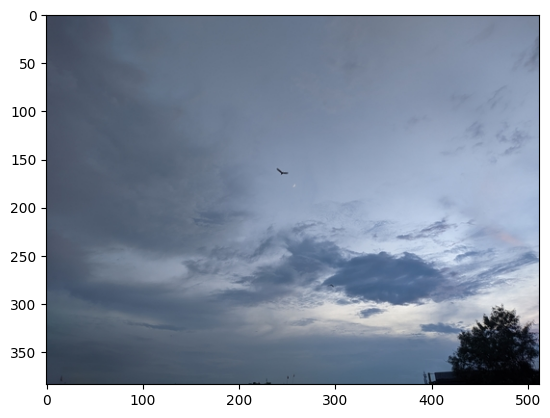

In [16]:
selected_image = get_random_image(image_dir)
plot_image(selected_image)

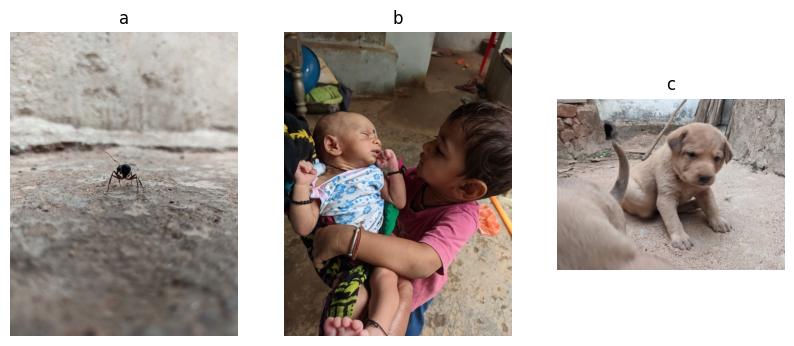

In [17]:
tri = [get_random_image(image_dir) for _ in  range(3)]
plot_images_grid(tri, titles=["a", "b", "c"], grid_size=(1,3))

In [18]:
out = db.get_n_similar_images(tri, k=4)
sim_files = out["uris"] 
dists = out["distances"]
# sim_files, dists

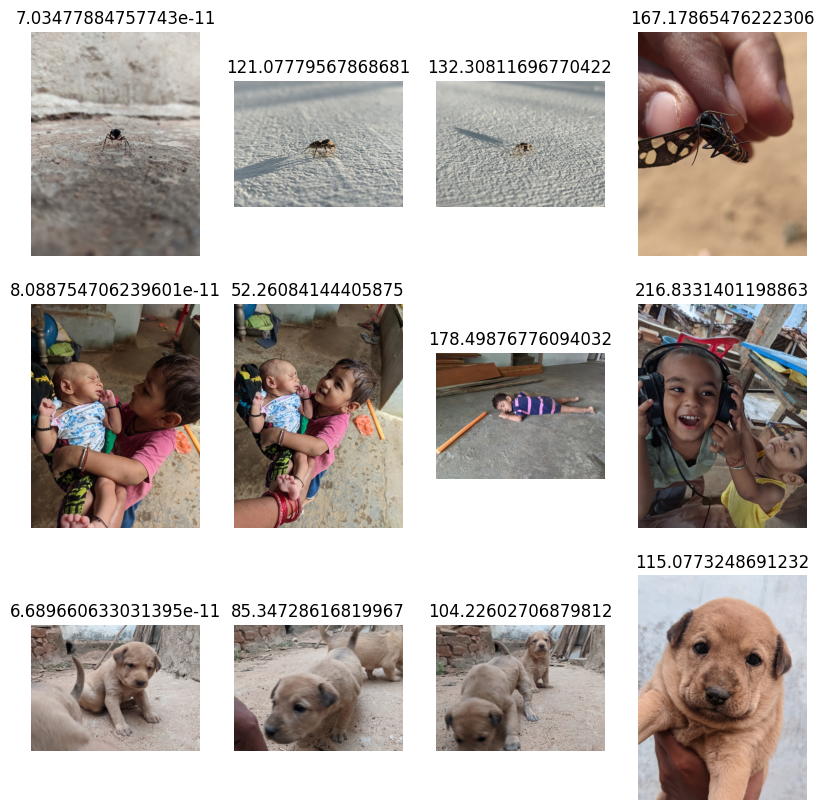

In [19]:
plot_images_grid(np.ravel(sim_files), titles=np.ravel(dists), grid_size=[3, 4]) 

In [20]:
new_folder = Path("./samples2")
db.update_images(image_paths=[str(i.absolute()) for i in new_folder.iterdir()])

Added 45 new images.


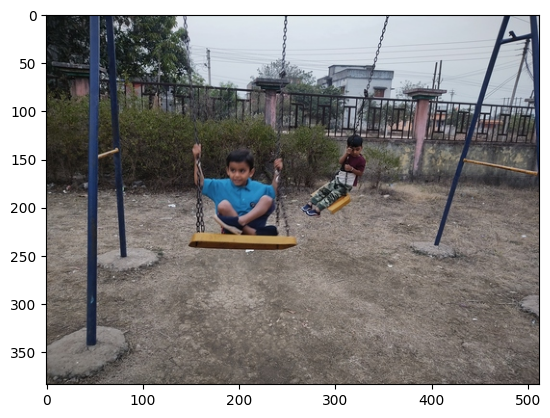

In [21]:
trii = get_random_image(new_folder)
plot_image(trii)

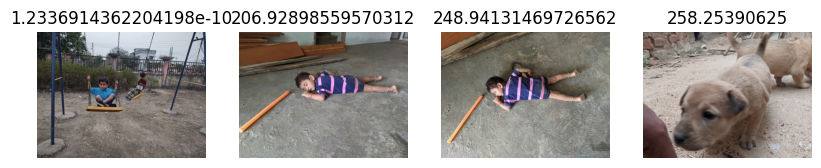

In [22]:
out = db.get_n_similar_images(trii, k=4)
sim_files = out["uris"] 
dists = out["distances"]
# sim_files, dists
plot_images_grid(np.ravel(sim_files), titles=np.ravel(dists), grid_size=[1, 4]) 

In [23]:
db.delete_embeddings(dir=new_folder)

deleted 45 embeddins!


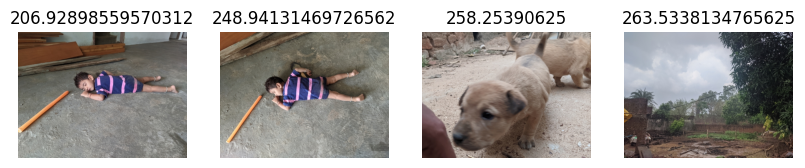

In [28]:
out = db.get_n_similar_images(trii, k=4)
sim_files = out["uris"] 
dists = out["distances"]
# sim_files, dists
plot_images_grid(np.ravel(sim_files), titles=np.ravel(dists), grid_size=[1, 4]) 

In [24]:
# new_images = [str(i.absolute()) for i in new_folder.iterdir()]

In [25]:
# ss = db.collection.query(query_uris=new_images, include=["uris", "distances", "metadatas", "embeddings", "documents"], n_results=2)

In [26]:
# new_images[:10]

In [27]:
# ss